<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_embeddings_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.8 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


load nursing notes subject-caregiver-chartdate

In [53]:
import pandas as pd
import numpy as np
notes_path = "/content/drive/MyDrive/NIH/Data/"
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
#notes_name = "NOTES_NURSING_NEONATOLOGY.csv" # has young patient with matching notes
df_notes = pd.read_csv(notes_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65708 entries, 0 to 65707
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROW_ID      65708 non-null  int64 
 1   SUBJECT_ID  65708 non-null  int64 
 2   CGID        65708 non-null  int64 
 3   CHARTDATE   65708 non-null  object
 4   TEXT        65708 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.5+ MB


# **Data Preprocessing**

In [ ]:
callout_path = "/content/drive/MyDrive/NIH/Data/"
callout_name = "CALLOUT.csv"
df_callout = pd.read_csv(callout_path+callout_name)
df_callout.info()
df_callout['CURR_CAREUNIT'].unique()

In [55]:
df_notes_rory = pd.read_json('/content/drive/MyDrive/NIH/Data/annotated_burnout/rory.jsonl', lines=True)
df_notes_rory = df_notes_rory.rename(columns={'row_id': 'ROW_ID'})
df_notes_rory.dropna(subset='ROW_ID', inplace=True)
df_notes_rory['ROW_ID'] = df_notes_rory['ROW_ID'].round().astype(int)
df_neonatal = df_notes.merge(df_notes_rory, on='ROW_ID', how='inner')
print(df_notes_rory.sort_values('ROW_ID', ascending=True)['ROW_ID'])
print(df_notes.sort_values('ROW_ID', ascending=True)['ROW_ID'])
df_neonatal

36     1684173
38     1684179
35     1684217
34     1684219
33     1684226
        ...   
235    2062587
238    2062598
237    2062606
241    2074296
240    2082234
Name: ROW_ID, Length: 223, dtype: int64
65316    314506
48339    314516
47461    314521
10907    314522
52805    314526
          ...  
20403    738394
24390    738397
30139    738399
7773     738400
15588    738402
Name: ROW_ID, Length: 65708, dtype: int64


,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,id,text,cats,entities,Comments


## Data exploration 

number of notes: min=1, max=31, mean=1.5725636607313804


<Axes: xlabel='TEXT'>

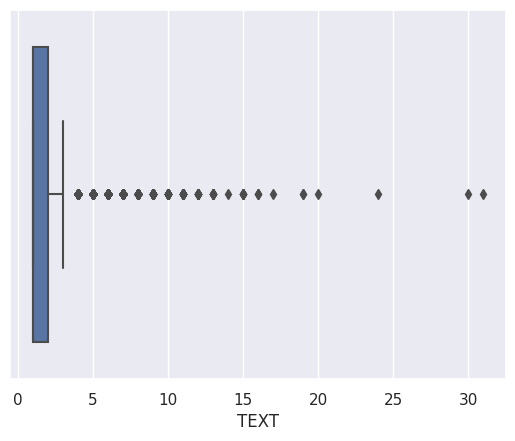

In [6]:
import seaborn as sns
sns.set()


gb_notes = df_notes.groupby(['CGID','SUBJECT_ID'])
num_notes = gb_notes['TEXT'].count()

print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()}')
sns.boxplot(x=num_notes)

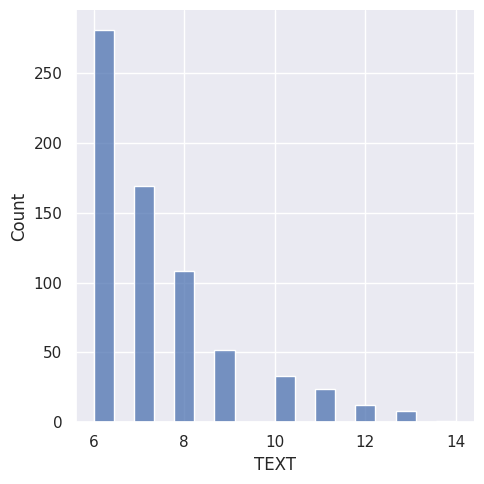

In [7]:
sns.displot(num_notes[((num_notes>5) & (num_notes<15))])
 

# **Data preprocessing**

In [8]:
# grab all key pairs of CGID and SUBJECTID from df group
groups = gb_notes['TEXT'].groups
group_keys = list(gb_notes['TEXT'].groups.keys()) # list of tuples
print(group_keys)
print(gb_notes.get_group(group_keys[0])['TEXT'])
# currently not used

[(14023, 199), (14023, 2090), (14023, 3874), (14023, 5771), (14023, 10954), (14023, 11993), (14023, 13123), (14023, 15722), (14023, 16934), (14023, 18902), (14023, 23162), (14023, 23568), (14023, 24677), (14023, 27577), (14023, 40461), (14023, 41603), (14023, 41897), (14023, 42066), (14023, 42160), (14023, 42525), (14023, 44490), (14023, 45985), (14023, 46499), (14023, 46569), (14023, 46582), (14023, 46642), (14023, 46836), (14023, 47785), (14023, 48373), (14023, 48555), (14023, 49029), (14023, 49104), (14023, 49112), (14023, 49594), (14023, 49597), (14023, 49615), (14023, 50063), (14023, 50488), (14023, 50819), (14023, 52069), (14023, 52296), (14023, 52535), (14023, 52657), (14023, 53269), (14023, 54247), (14023, 54398), (14023, 54724), (14023, 55180), (14023, 55370), (14023, 55895), (14023, 56110), (14023, 56478), (14023, 56565), (14023, 56892), (14023, 57063), (14023, 57183), (14023, 57739), (14023, 58312), (14023, 58700), (14023, 58774), (14023, 59425), (14023, 60362), (14023, 6043

In [9]:
# sample data that will be entered into model
sample_sentences = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'Horse is eating grass.',
          'A man is eating pasta.',
          'A Woman is eating Biryani.',
          'The girl is carrying a baby.',
          'The baby is carried by the woman',
          'A man is riding a horse.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.',
          'A cheetah is running behind its prey.',
          'A cheetah chases prey on across a field.',
          'The cheetah is chasing a man who is riding the horse.',
          'man and women with their baby are watching cheetah in zoo'
          ]
  
sentences = df_notes[ (df_notes['CGID'] == 14151) & (df_notes['SUBJECT_ID'] == 40577) ]['TEXT'].to_list()
for sentence in sentences:
  print(sentence)
  print('\n\n\n')



52 year old male sp motorcycle crash at estimated 70 mph. Intubated
   prior to arrival, hypotensive and bradycardic in ED. Resuscitated with
   large volume crystalloid and PRBCs and directly to OR. Pt has extensive
   PMHx including significant cardiac disease and CRI with baseline
   creatinine of 2.0.
   Injuries include:
   (1)     Bil Elbow fractures with extensive degloving injuries.
   (2)     R Knee degloving
   (3)     Large R groin laceration-no vessels involved.
   (4)     Larceration to L side of nose with abrasions.
   (5)     Abdominal abrasions and incision with fascia closed and dermis
   left open
   Procedures;
           (1) [**11-8**] to OR from ED for Abdominal ex-lap +for blood in
   abdomen without visible source, dermis left open with exposed lap band
   port. BUEs exploration and wash-out   with bilaterally VAC dressings.
   Exploration and wash out of L groin wound with w-d packing. Transiently
   requiring pressors, cont blood products txs post-op.
   (2) [*

In [10]:
# filter cgid and subjectid pairs to contain between a certain number of notes

#print(df_notes['CGID'].unique())
new_df = df_notes.groupby(['CGID','SUBJECT_ID'])['TEXT'].count()
new_df = new_df.reset_index()
new_df = new_df.rename(columns={'TEXT':'COUNT'})
df_filtered = new_df.loc[ (new_df['COUNT'] > 5) & (new_df['COUNT'] < 9) ].reset_index()
print(df_filtered)

     index   CGID  SUBJECT_ID  COUNT
0      156  14151       40577      8
1      159  14151       41034      6
2      204  14151       58928      6
3      223  14151       67529      8
4      262  14151       78518      7
..     ...    ...         ...    ...
553  41496  21452        1709      7
554  41537  21452       31942      8
555  41564  21452       50859      7
556  41608  21452       70516      8
557  41671  21452       94698      8

[558 rows x 4 columns]


In [11]:
# loop through entire list of caregiver and subject pairs

# loop with groupby
#for Cg_Subject_Pair in group_keys:
  #df_notes[ (df_notes['CGID'] == Cg_Subject_Pair[0]) & (df_notes['SUBJECT_ID'] == Cg_Subject_Pair[1]) ]['TEXT'].to_list()
  #print(Cg_Subject_Pair[0],Cg_Subject_Pair[1])

# loop with dataframe
for Cg_Subject_Pair in df_filtered.iterrows():
  print(f"CGID:{Cg_Subject_Pair[1]['CGID']} SUBID:{Cg_Subject_Pair[1]['SUBJECT_ID']}")
  df_notes[ (df_notes['CGID'] == Cg_Subject_Pair[1]['CGID']) & (df_notes['SUBJECT_ID'] == Cg_Subject_Pair[1]['SUBJECT_ID']) ]['TEXT'].to_list()


CGID:14151 SUBID:40577
CGID:14151 SUBID:41034
CGID:14151 SUBID:58928
CGID:14151 SUBID:67529
CGID:14151 SUBID:78518
CGID:14182 SUBID:30829
CGID:14214 SUBID:10774
CGID:14214 SUBID:64798
CGID:14214 SUBID:80274
CGID:14214 SUBID:84461
CGID:14228 SUBID:54247
CGID:14228 SUBID:56854
CGID:14228 SUBID:76222
CGID:14228 SUBID:89062
CGID:14357 SUBID:70516
CGID:14357 SUBID:87743
CGID:14357 SUBID:98593
CGID:14411 SUBID:27427
CGID:14411 SUBID:27472
CGID:14411 SUBID:30139
CGID:14411 SUBID:66508
CGID:14411 SUBID:80927
CGID:14411 SUBID:90538
CGID:14419 SUBID:18333
CGID:14419 SUBID:29765
CGID:14419 SUBID:59832
CGID:14419 SUBID:99491
CGID:14427 SUBID:78076
CGID:14427 SUBID:97542
CGID:14431 SUBID:31290
CGID:14431 SUBID:61213
CGID:14431 SUBID:94202
CGID:14435 SUBID:40577
CGID:14435 SUBID:51839
CGID:14435 SUBID:83570
CGID:14442 SUBID:28533
CGID:14442 SUBID:32414
CGID:14518 SUBID:58662
CGID:14518 SUBID:74835
CGID:14542 SUBID:49358
CGID:14542 SUBID:77560
CGID:14576 SUBID:46656
CGID:14576 SUBID:50454
CGID:14576 

## Embeddings 

In [12]:
model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [13]:
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
  model_output = model(**encoded_input)

for k,v in encoded_input.items():
  print(k)
  print(v.numpy())

input_ids
[[  101  4720  2095 ... 11888  3255   102]
 [  101  4720  2095 ...  3456  2058   102]
 [  101  9016  1010 ...     0     0     0]
 ...
 [  101  2824  1024 ...     0     0     0]
 [  101  2516  1024 ...     0     0     0]
 [  101 10089  7667 ...     0     0     0]]
token_type_ids
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
attention_mask
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [14]:
token_embeddings = model_output.last_hidden_state
print(token_embeddings.size())
print('num of sentences, num of tokens, embed dim')
print('ONE EMBEDDING VECTOR PER TOKEN')

torch.Size([8, 512, 384])
num of sentences, num of tokens, embed dim
ONE EMBEDDING VECTOR PER TOKEN


In [15]:
def mean_pooling(model_output, attention_mask):
  token_embeddings = model_output.last_hidden_state
  input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
  return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)
print('ONE EMBEDDING VECTOR PER SENTENCE')

Sentence embeddings:
tensor([[-0.0394, -0.0165,  0.0390,  ..., -0.0023, -0.0041,  0.0138],
        [-0.0274, -0.0235,  0.0126,  ..., -0.0115, -0.0093,  0.0223],
        [-0.0179,  0.0127, -0.0381,  ..., -0.0345, -0.0261, -0.0044],
        ...,
        [-0.0352, -0.0391, -0.0051,  ..., -0.0909,  0.0171,  0.0098],
        [-0.0299, -0.0047, -0.0345,  ..., -0.0693, -0.0741,  0.0214],
        [-0.0243, -0.0256, -0.0032,  ..., -0.0181, -0.0996,  0.0161]])
ONE EMBEDDING VECTOR PER SENTENCE


In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

sentence_embeddings_np = sentence_embeddings.detach().numpy()

scores = np.zeros((sentence_embeddings_np.shape[0],sentence_embeddings_np.shape[0]))
dist = []
for idx in range(sentence_embeddings_np.shape[0]):
  scores[idx,:] = cosine_similarity([sentence_embeddings_np[idx]],sentence_embeddings_np)[0]            
  if idx < len(sentence_embeddings_np)-1:
    dist.append(scores[idx,idx+1])

scores     

array([[0.99999988, 0.92559719, 0.65373111, 0.62693524, 0.67897218,
        0.63586247, 0.62395692, 0.5566029 ],
       [0.92559719, 0.99999988, 0.64192617, 0.61476386, 0.60430825,
        0.60875779, 0.53871596, 0.47071207],
       [0.65373111, 0.64192617, 1.00000012, 0.96904504, 0.76145911,
        0.72633278, 0.75415707, 0.59435105],
       [0.62693524, 0.61476386, 0.96904504, 1.00000012, 0.75251949,
        0.73662257, 0.74104422, 0.5781253 ],
       [0.67897218, 0.60430825, 0.76145911, 0.75251949, 1.00000024,
        0.72554851, 0.78717375, 0.68833739],
       [0.63586247, 0.60875779, 0.72633278, 0.73662257, 0.72554851,
        1.00000012, 0.68371177, 0.62954491],
       [0.62395692, 0.53871596, 0.75415707, 0.74104422, 0.78717375,
        0.68371177, 0.99999988, 0.67332351],
       [0.5566029 , 0.47071207, 0.59435105, 0.5781253 , 0.68833739,
        0.62954491, 0.67332351, 1.        ]])

<Axes: >

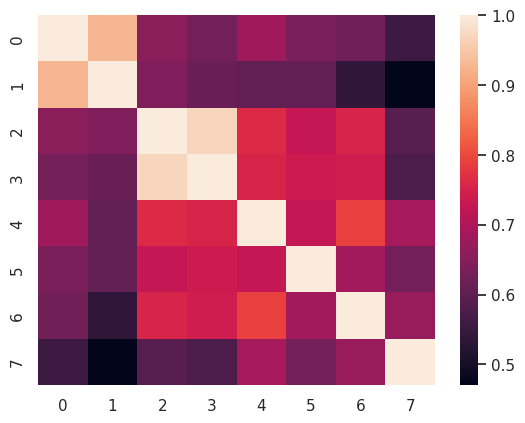

In [17]:
import seaborn as sns
sns.set()

sns.heatmap(scores)

<Axes: >

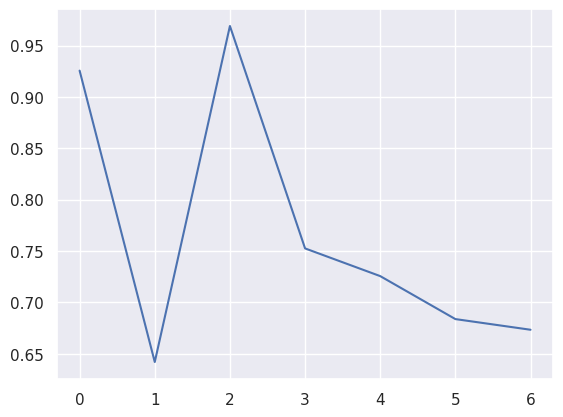

In [18]:
sns.lineplot(dist)

## Clustering 

In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [20]:
clustering_model = KMeans(n_clusters=3)
clustering_model.fit(sentence_embeddings_np)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

[0 0 1 1 1 1 1 2]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(sentences[sentence_id])
clustered_sentences

{0: ['52 year old male sp motorcycle crash at estimated 70 mph. Intubated\n   prior to arrival, hypotensive and bradycardic in ED. Resuscitated with\n   large volume crystalloid and PRBCs and directly to OR. Pt has extensive\n   PMHx including significant cardiac disease and CRI with baseline\n   creatinine of 2.0.\n   Injuries include:\n   (1)     Bil Elbow fractures with extensive degloving injuries.\n   (2)     R Knee degloving\n   (3)     Large R groin laceration-no vessels involved.\n   (4)     Larceration to L side of nose with abrasions.\n   (5)     Abdominal abrasions and incision with fascia closed and dermis\n   left open\n   Procedures;\n           (1) [**11-8**] to OR from ED for Abdominal ex-lap +for blood in\n   abdomen without visible source, dermis left open with exposed lap band\n   port. BUEs exploration and wash-out   with bilaterally VAC dressings.\n   Exploration and wash out of L groin wound with w-d packing. Transiently\n   requiring pressors, cont blood products

In [22]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 8)
X = sentence_embeddings_np 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'cosine'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

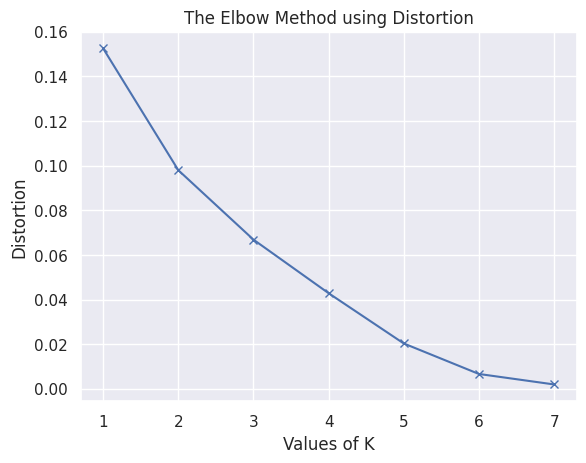

In [23]:
import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()